In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import vaex
from matplotlib import pyplot as plt


from shapely.geometry import Point
from shapely.ops import unary_union

import statsmodels.api as sm
import matplotlib.colors as colors

from datetime import datetime
from typing import Any, Dict, Tuple

pd.set_option('display.max_columns', None)

In [5]:
path = '/home/yoshraf/projects/master-analysis-inequality-mobility/inequality-mobility/data/01_raw/external/'

In [6]:
# Read all the IPTU data and concatenate into a unique dataframe
dfs = []
date_ini, date_end  = 1995, 2025
for year in range(date_ini, date_end + 1):
    dfs.append(vaex.open(f'{path}/IPTU-HDF5/IPTU_{year}/IPTU_{year}.hdf5'))
df_iptu = vaex.concat(dfs)

# Create the id for the block 'sq'
df_iptu['setor'] = df_iptu['NUMERO DO CONTRIBUINTE'].str.slice(0,3)
df_iptu['quadra'] = df_iptu['NUMERO DO CONTRIBUINTE'].str.slice(3,6)
df_iptu['sq'] = df_iptu['setor'] + df_iptu['quadra']
# Standlize the string format
df_iptu['TIPO DE USO DO IMOVEL'] = df_iptu['TIPO DE USO DO IMOVEL'].str.capitalize()

def agg_type(gdf):
    '''
    This function aggregates the unit (taxpayer) to block level.
    
    Taxpayer -> Building Unit (Stret + Number) -> Block
    '''
    
    # Create the id for building unit
    gdf['unit'] = gdf['NOME DE LOGRADOURO DO IMOVEL'] + gdf['NUMERO DO IMOVEL'].astype(str)
    
    # How many rows
    print(gdf.shape)
    
    # Agg by the unit
    df_aux_b = gdf.groupby(
        ['sq', 'unit'],
        progress=True
                          ).agg(
        {
             'VALOR DO M2 DE CONSTRUCAO': 'mean',
             'VALOR DO M2 DO TERRENO': 'mean',
        }
    )
    # Agg by block
    print(df_aux_b.shape)
    df_aux_b2 = df_aux_b.groupby(['sq']).agg(
        {
         'VALOR DO M2 DE CONSTRUCAO': 'mean',
         'VALOR DO M2 DO TERRENO': 'mean',
        }
    )
    print(df_aux_b2.shape)
    df_agg2 = df_aux_b2.to_pandas_df()
    return df_agg2

df_results = agg_type(df_iptu)

(93422464, 33)
groupby [########################################] 100.00% elapsed time  :    12.00s =  0.2m =  0.0h 
groupby [########################################] 100.00% elapsed time  :    26.52s =  0.4m =  0.0h
 (6118133, 4)
(46478, 3)


In [7]:
gdf_quadras = gpd.read_file(f'{path}quadras.gpkg')

In [8]:
df_results = pd.merge(
    gdf_quadras[['sq', 'geometry']],
    df_results,
    on=['sq']
)
df_results['LOG VALOR DO M2 DE CONSTRUCAO'] = np.log(df_results['VALOR DO M2 DE CONSTRUCAO'])
df_results['LOG VALOR DO M2 DO TERRENO'] = np.log(df_results['VALOR DO M2 DO TERRENO'])

/home/yoshraf/projects/master-analysis-inequality-mobility/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
log_col = 'LOG VALOR DO M2 DO TERRENO'
col = 'VALOR DO M2 DO TERRENO'

In [10]:
def gini(x):
    # sort the values in ascending order
    sorted_x = np.sort(x)
    
    # calculate the cumulative sum of the values
    cumsum_x = np.cumsum(sorted_x[::-1])
    
    # calculate the Lorenz curve
    lorenz_curve = cumsum_x / cumsum_x[-1]
    return lorenz_curve

lorenz_curve = gini(df_results[col])

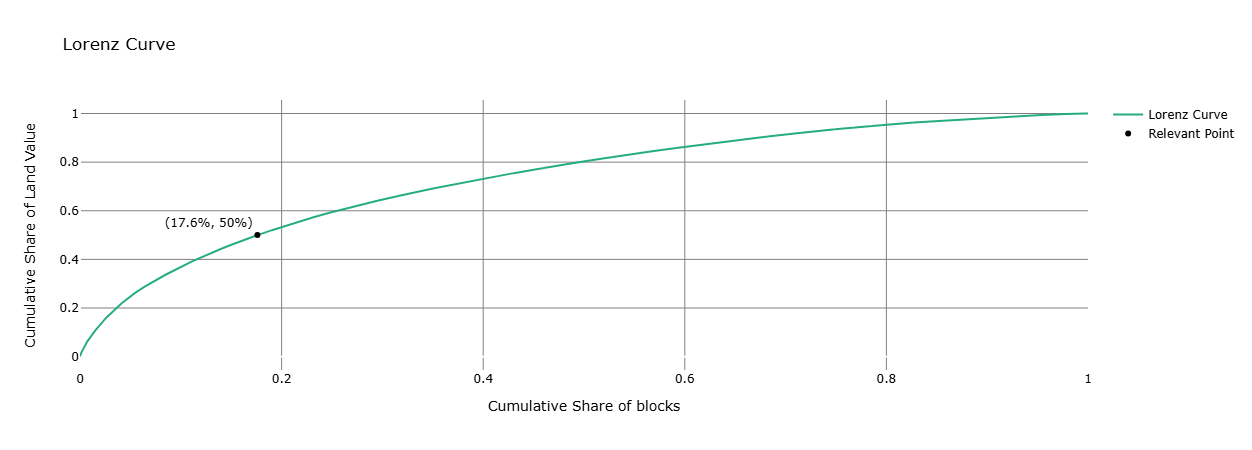

In [12]:
import plotly.graph_objects as go
from plotly.graph_objs import *

f_color_t = 'rgba(72, 28, 110, .3)'
f_color_c = 'rgba(37, 172, 130, .3)'
color_t = 'rgba(72, 28, 110, 1)'
color_c = 'rgba(37, 172, 130, 1)'

layout = Layout(
        paper_bgcolor='white',
        plot_bgcolor='white'
    )

fig = go.Figure(
    [
        go.Scatter(
            x=np.linspace(0, 1, len(lorenz_curve)),
            y=lorenz_curve,
            mode='lines',
            name='Lorenz Curve',
            line=dict(color=color_c),
        ),
        
    ], 
    layout=layout
)

fig.add_scatter(
    x=[0.176], y=[0.5],
    mode='markers+text',
    name='Relevant Point',
    text="(17.6%, 50%)",
    line=dict(color='black'), 
#     textfont=dict(color='#E8D202')
)
fig.update_traces(textposition='top left')


f=.5
fig.update_layout(
    title='Lorenz Curve',
    xaxis_title='Cumulative Share of blocks',
    yaxis_title='Cumulative Share of Land Value',
    font_color="black",
    width=1600*f,
    height=900*f,
    )
fig.update_xaxes(showline=False, gridcolor='grey', linewidth=1)
fig.update_yaxes(showline=False, gridcolor='grey', linewidth=1)
fig.write_image(f'figs/lorenz.png')
fig.show()